
<br>
Initializing an empty-weighted Unet and training it on the CUB dataset.<br>
Serves as a baseline model for the<br>


In [38]:
import torch
import segmentation_models_pytorch as smp 
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import json
from dataloaders import create_train_val_test_loaders
from tqdm import tqdm

## Hyperparams

In [ ]:
MAXEPOCHS = 10
BATCHSIZE = 4
MOMENTUM = 0.99
LEARNING_RATE = 0.01
NUM_CLASSES = 2

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model, optimizer, loss definitions -------------------------------------------------------------<br>
vanilla unet, untrained

In [41]:
unet = smp.Unet(
    encoder_name="resnet34",  
    encoder_weights=None,  
    in_channels=3,  
    classes=NUM_CLASSES,
)
unet.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [42]:
optimizer = torch.optim.SGD(unet.parameters(),
                           lr=LEARNING_RATE,
                           momentum=MOMENTUM)

In [43]:
lossFunc = torch.nn.CrossEntropyLoss()

Data loaders ------------------------------------------------------------------------------------

In [44]:
path_images_folder = os.path.join("../CUBdata/CUB_200_2011/images/")
path_segmentations_folder = os.path.join("../CUBdata/segmentations/")

In [45]:
training_dataloader, validation_dataloader, testing_dataloader = create_train_val_test_loaders(
    image_dir=path_images_folder, 
    segmentation_dir=path_segmentations_folder,
    batch_size=BATCHSIZE
)

Dataset loaded with 11788 image-segmentation pairs


# Training

In [46]:
def visualize_training_process(metrics):
    """Visualize the final training process metrics"""
    plt.figure(figsize=(8, 5))
    plt.plot(metrics['epochs'], metrics['train_loss'], 'bo-', label='Training Loss')
    plt.plot(metrics['epochs'], metrics['val_loss'], 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("outputs/final_training_metrics.png")
    plt.close()


## ROC AUC Visualization
This section adds ROC AUC tracking and visualization. Per-epoch metrics are written to disk to avoid memory bottlenecks.

In [47]:
from sklearn.metrics import roc_auc_score
import json


In [48]:
from tqdm import tqdm
import os
import json
from torchmetrics.classification import BinaryAUROC


def train():
    output_dir = "outputs"
    os.makedirs(output_dir, exist_ok=True)
    metrics_path = os.path.join(output_dir, "epoch_metrics.json")
    # Initialize metrics file
    with open(metrics_path, 'w') as f:
        json.dump([], f)

    best_val_loss = float('inf')
    val_auc_metric = BinaryAUROC(thresholds=128, ignore_index=True).to(device)

    for epoch in range(1, MAXEPOCHS + 1):
        # --- Training Phase ---
        unet.train()
        train_loss = 0.0
                for images, masks in tqdm(training_dataloader, desc=f"Epoch {epoch}/{MAXEPOCHS} [Train]", leave=False, ncols=80):
            images = images.to(device)
            masks  = masks.to(device).long()

            optimizer.zero_grad()
            logits = unet(images)
            loss = lossFunc(logits, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        avg_train_loss = train_loss / len(training_dataloader)
        
        # --- Validation Phase ---
        unet.eval()
        val_loss = 0.0
        val_auc_metric.reset()
        with torch.no_grad():
            for images, masks in tqdm(validation_dataloader, desc=f"Epoch {epoch}/{MAXEPOCHS} [Val]", leave=False, ncols=80):
                images = images.to(device)
                masks  = masks.to(device).long()
                logits = unet(images)
                val_loss += lossFunc(logits, masks).item()

                probs = torch.softmax(logits, dim=1)[:, 1].flatten()
                val_auc_metric.update(probs, masks.flatten())

        avg_val_loss = val_loss / len(validation_dataloader)
        val_auc = val_auc_metric.compute().item()

        # Learning rate
        lr = optimizer.param_groups[0]['lr']

        # Checkpoint best model by val loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(unet.state_dict(), os.path.join(output_dir, 'best_model.pth'))

        # Log metrics
        with open(metrics_path, 'r+') as f:
            data = json.load(f)
            data.append({
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                                'val_auc': val_auc,
                'lr': lr
            })
            f.seek(0)
            json.dump(data, f, indent=2)
            f.truncate()

        print(f"Epoch {epoch:2d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
              f"| Val AUC: {val_auc:.4f} | LR: {lr:.6f}")

    print(f"Training complete. Metrics written to {metrics_path}")


In [54]:

def test():
    unet.eval()
    tloss = 0.0

    # Set up streaming AUC metric
    auc_metric = BinaryAUROC(thresholds=128).to(device)

    sample_idx = 0
    fig, axes = plt.subplots(4, 3, figsize=(15, 10))

    with torch.no_grad():
        for image, segmentation_mask in testing_dataloader:
            image = image.to(device)
            segmentation_mask = segmentation_mask.to(device).long()

            logits = unet(image)
            tloss += lossFunc(logits, segmentation_mask).item()

            # Update AUC metric
            probs = torch.softmax(logits, dim=1)[:, 1].flatten()
            targets = segmentation_mask.flatten()
            auc_metric.update(probs, targets)

            # Visualize a few samples
            if sample_idx < 4:
                axes[sample_idx, 0].imshow(image[0].cpu().permute(1, 2, 0))
                axes[sample_idx, 0].set_title(f"Sample {sample_idx+1}: Original")
                axes[sample_idx, 0].axis('off')

                axes[sample_idx, 1].imshow(segmentation_mask[0].cpu(), cmap='gray')
                axes[sample_idx, 1].set_title(f"Sample {sample_idx+1}: Ground Truth")
                axes[sample_idx, 1].axis('off')

                pred_mask = torch.argmax(logits, dim=1)[0].cpu()
                axes[sample_idx, 2].imshow(pred_mask, cmap='gray')
                axes[sample_idx, 2].set_title(f"Sample {sample_idx+1}: Prediction")
                axes[sample_idx, 2].axis('off')

                sample_idx += 1

    # Finalize visualization
    plt.tight_layout()
    plt.savefig("outputs/test_samples_visualization.png")
    plt.close()

    # Compute average loss and AUC
    avg_test_loss = tloss / len(testing_dataloader)
    test_auc = auc_metric.compute().item()

    # Save metrics
    test_metrics = {
        'test_loss': avg_test_loss,
        'test_auc': test_auc
    }
    with open('outputs/test_metrics.json', 'w') as f:
        json.dump(test_metrics, f)

    print(f"Test: Loss={avg_test_loss:.4f}  ROC-AUC={test_auc:.4f}")
    return test_metrics

In [55]:
import matplotlib.pyplot as plt
import json

def plot_metrics():
    with open("outputs/epoch_metrics.json", 'r') as f:
        data = json.load(f)
    epochs = [d['epoch'] for d in data]
    train_loss = [d['train_loss'] for d in data]
    val_loss = [d['val_loss'] for d in data]
    val_auc = [d['val_auc'] for d in data]
    lr = [d['lr'] for d in data]
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(2,1,2)
    plt.plot(epochs, val_auc, 'r-', label='Val ROC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Validation ROC AUC')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("outputs/final_training_metrics.png")
    plt.show()

Model already trained. To retrain, delete the 'outputs/best_model.pth' file.
 Going ahead with testing...
Test: Loss=0.2076  ROC-AUC=0.9483

Testing completed successfully.


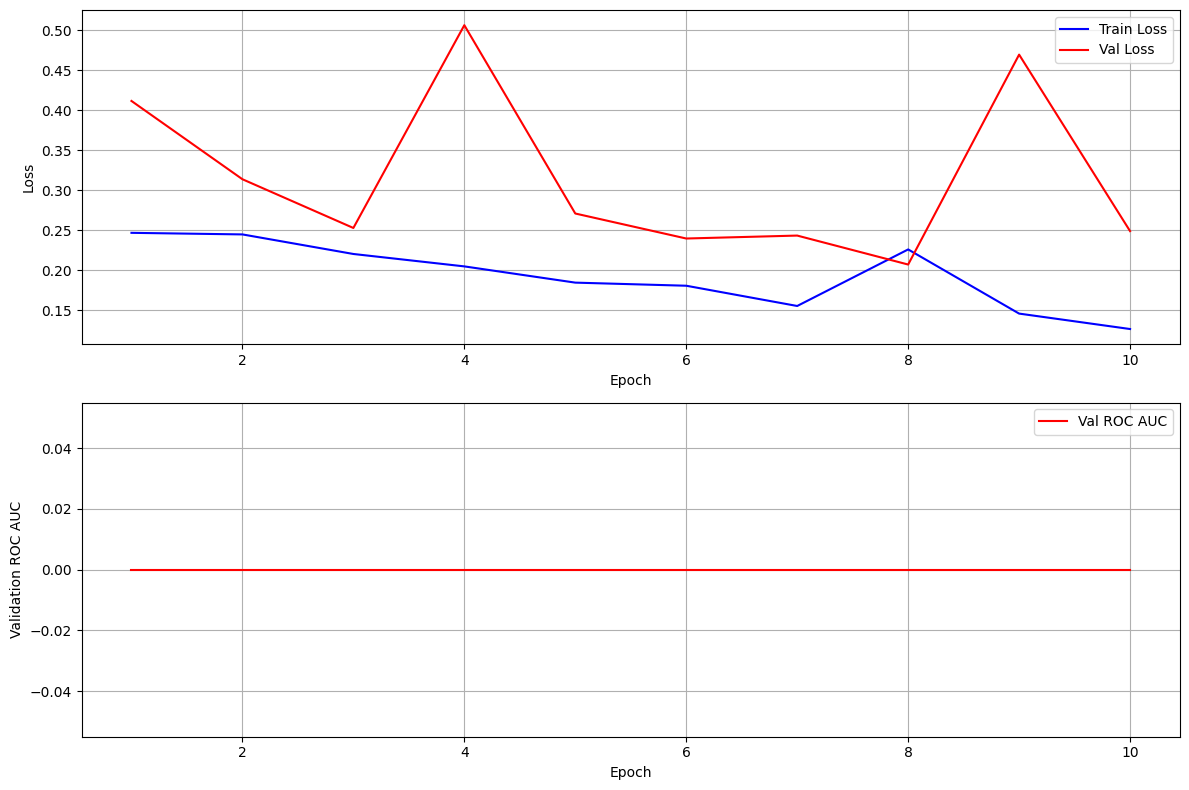

In [56]:
if __name__ == "__main__":
    # Create outputs directory if it doesn't exist
    os.makedirs("outputs", exist_ok=True)
    if os.path.exists("outputs/best_model.pth"):
        print("Model already trained. To retrain, delete the 'outputs/best_model.pth' file.\n Going ahead with testing...")

        # Load best model

        unet = smp.Unet(
            encoder_name="resnet34",  
            encoder_weights=None,  
            in_channels=3,  
            classes=NUM_CLASSES,
        )
        unet.load_state_dict(torch.load("outputs/best_model.pth"))
        unet.to(device)

        test_metrics = test()
        print("\nTesting completed successfully.")
        plot_metrics()
    else:
        if device.type == "cuda":
            print("Starting training process...")
            train()
            print("\nStarting testing process...")
            test_metrics = test()
            print("\nTraining and testing completed successfully.")
            print("\t * Results and visualizations saved in the 'outputs' directory. * ")

            plot_metrics()

        else:
            print("No GPU available, exiting...")

In [ ]:
import random

def inference_from_paths(testing_dataloader, n=5):
    # limit to 20 samples
    """
    Samples n random datapoints from the test set using the underlying dataset's image paths,
    loads and visualizes both the true and predicted segmentation masks.
    """
    # Try to access the dataset object and its image paths
    dataset = testing_dataloader.dataset
    if hasattr(dataset, 'dataset'):
        # This is a Subset, get the original dataset
        base_dataset = dataset.dataset
        indices = dataset.indices
        image_paths = [base_dataset.image_paths[i] for i in indices]
    else:
        image_paths = dataset.image_paths

    total_samples = len(image_paths)
    n = min(n, 10)                                          
    indices = random.sample(range(total_samples), n)

    unet.load_state_dict(torch.load("outputs/best_model.pth", map_location=device))
    unet.eval()

    plt.figure(figsize=(6, n * 3))
    for i, idx in enumerate(indices):
        # Get sample from dataset by index
        image, true_mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        true_mask_np = true_mask.cpu().numpy()

        with torch.no_grad():
            logits = unet(image_input)
            pred_mask = torch.argmax(logits, dim=1)[0].cpu().numpy()

        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(image.cpu().permute(1, 2, 0))
        plt.title(f"Sample {i+1}: Image")
        plt.axis('off')

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


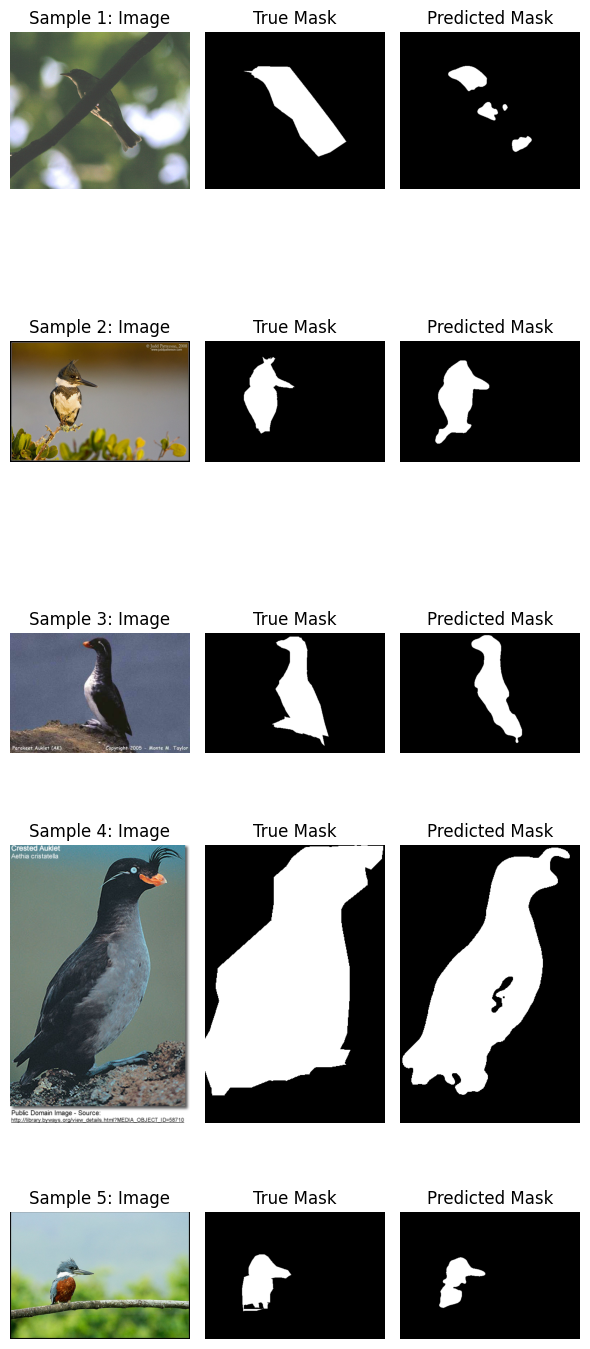

In [60]:
inference_from_paths(testing_dataloader, n=5)